In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

PROTEIN_NAME = "Spike"

BACKGROUND_NUM_FILE = "output/background_num.csv"
MUTATION_NUM_FILE = "output/mutation_num_Spike.csv"
PARAFIXSITES_FILE = "output/nextstrain_sitePath_results.csv"

FIRST_DATE_PLOT = "plots/first_date.pdf"

VARIANT_NAMES = ("Alpha-related", "Delta-related", "", "Gamma-related", "")
SITES_TO_PLOT = pd.DataFrame.from_records([
    (501, 156, 18, 190, 152),
    (681, 681, 20, 417, 701),
    (716, 452, 26, 484, 1027),
    (1118, 950, 138, 655, 1176)
], columns=VARIANT_NAMES)


In [2]:
paraFix_sites = pd.read_csv(PARAFIXSITES_FILE)
paraFix_sites = paraFix_sites.rename(columns={"product": "protein"})
paraFix_sites = paraFix_sites[paraFix_sites["protein"] == PROTEIN_NAME]
paraFix_sites["date"] = pd.to_datetime(paraFix_sites["date"])
paraFix_sites = paraFix_sites.sort_values("date")
paraFix_sites = paraFix_sites[["date", "protein", "aaPos", "paraFixMut"]]
paraFix_sites = paraFix_sites[paraFix_sites["aaPos"].isin(SITES_TO_PLOT.unstack().unique())]
paraFix_sites = paraFix_sites[~paraFix_sites["paraFixMut"].isna()]


In [3]:
bg_num = pd.read_csv(BACKGROUND_NUM_FILE)
bg_num["Date"] = pd.to_datetime(bg_num["Date"])
bg_num = bg_num.groupby("Date").sum().reset_index()

mut_num = pd.read_csv(MUTATION_NUM_FILE)
mut_num["Date"] = pd.to_datetime(mut_num["Date"])
mut_num = mut_num.groupby(["Date", "Site"]).sum().reset_index()


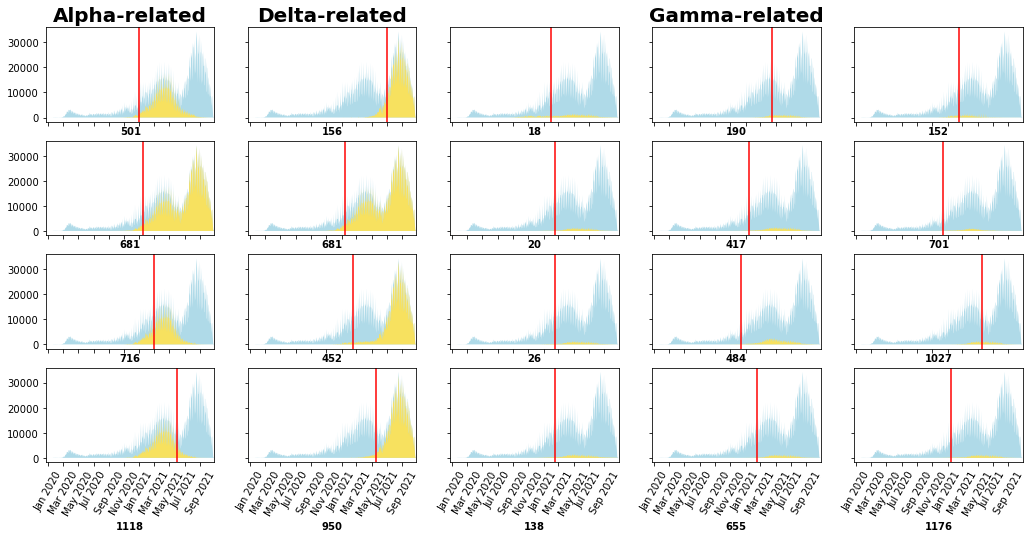

In [4]:
nrows = len(SITES_TO_PLOT.index)
ncols = len(SITES_TO_PLOT.columns)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    figsize = (3.5 * ncols, 8)
)

x_pos = bg_num["Date"].values
x_pos.sort()

for i in range(nrows):
    for j in range(ncols):
        variant_name = VARIANT_NAMES[j]
        site_name = SITES_TO_PLOT.iloc[i, j]
        site_num = mut_num[mut_num["Site"] == site_name]

        ax = axes[i][j]
        ax.fill_between(bg_num["Date"], 0, bg_num["Total_num"], label = "Backgroup", facecolor='#AFDAE8')
        ax.fill_between(site_num["Date"], 0, site_num["Mut_num"], label = "mutation", facecolor='#F7E15F')

        first_date = paraFix_sites.loc[paraFix_sites["aaPos"] == site_name, "date"].min()
        ax.axvline(x=first_date, color="red")

        ax.tick_params(axis='x', labelrotation=60)
        ax.set_xlim([x_pos[1], x_pos[-1]])
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        ax.set_xlabel(site_name, fontweight='bold')
        if i == 0:
            ax.set_title(variant_name, fontsize=20, fontweight="bold")

plt.savefig(FIRST_DATE_PLOT, bbox_inches="tight")
plt.show()
plt.close()
